In [2]:
!pip install transformers Pillow torch requests

In [4]:
!pip install -U transformers

  Using cached transformers-4.56.1-py3-none-any.whl.metadata (42 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.6/11.6 MB 60.6 MB/s  0:00:0064.2 MB/s eta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.9/2.9 MB 49.9 MB/s  0:00:00
  Attempting uninstall: tokenizers
    Found existing installation: tokenizers 0.20.3
    Uninstalling tokenizers-0.20.3:
      Successfully uninstalled tokenizers-0.20.3
  Attempting uninstall: transformers
    Found existing installation: transformers 4.46.3
    Uninstalling transformers-4.46.3:
      Successfully uninstalled transformers-4.46.3
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2/2 [transformers]0m 1/2 [transformers]


In [3]:
!pip install matplotlib

  Using cached contourpy-1.3.3-cp313-cp313-macosx_11_0_arm64.whl.metadata (5.5 kB)
  Using cached cycler-0.12.1-py3-none-any.whl.metadata (3.8 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.1/8.1 MB 40.6 MB/s  0:00:00 eta 0:00:01
Using cached contourpy-1.3.3-cp313-cp313-macosx_11_0_arm64.whl (274 kB)
Using cached cycler-0.12.1-py3-none-any.whl (8.3 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.8/2.8 MB 59.6 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6/6 [matplotlib] 5/6 [matplotlib]


In [ ]:
import requests
from transformers import RTDetrV2ForObjectDetection, RTDetrImageProcessor
import torch
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np

classes_map = {
    0: "Caption",
    1: "Footnote",
    2: "Formula",
    3: "List-item",
    4: "Page-footer",
    5: "Page-header",
    6: "Picture",
    7: "Section-header",
    8: "Table",
    9: "Text",
    10: "Title",
    11: "Document Index",
    12: "Code",
    13: "Checkbox-Selected",
    14: "Checkbox-Unselected",
    15: "Form",
    16: "Key-Value Region",
}

# Define distinct colors for each class
class_colors = {
    0: "#FF6B6B",  # Caption - Light Red
    1: "#4ECDC4",  # Footnote - Teal
    2: "#45B7D1",  # Formula - Blue
    3: "#96CEB4",  # List-item - Light Green
    4: "#FFEAA7",  # Page-footer - Light Yellow
    5: "#DDA0DD",  # Page-header - Plum
    6: "#98D8C8",  # Picture - Mint
    7: "#F7DC6F",  # Section-header - Gold
    8: "#BB8FCE",  # Table - Light Purple
    9: "#85C1E9",  # Text - Light Blue
    10: "#F8C471",  # Title - Orange
    11: "#82E0AA",  # Document Index - Light Green
    12: "#F1948A",  # Code - Salmon
    13: "#AED6F1",  # Checkbox-Selected - Pale Blue
    14: "#D5DBDB",  # Checkbox-Unselected - Light Gray
    15: "#F9E79F",  # Form - Light Yellow
    16: "#D7BDE2",  # Key-Value Region - Lavender
}


def annotate_image(image, boxes, labels, scores, save_path="annotated_image.png"):
    fig, ax = plt.subplots(1, figsize=(16, 10))
    ax.imshow(image)

    # Remove axes for cleaner look
    ax.set_xticks([])
    ax.set_yticks([])

    for box, label, score in zip(boxes, labels, scores):
        x_min, y_min, x_max, y_max = box
        width, height = x_max - x_min, y_max - y_min

        # Get class ID for color mapping
        class_id = None
        for k, v in classes_map.items():
            if v == label:
                class_id = k
                break

        color = class_colors.get(class_id, "#FF0000")  # Default to red if not found

        # Create a semi-transparent Rectangle overlay
        rect = patches.Rectangle(
            (x_min, y_min),
            width,
            height,
            linewidth=0,  # No border
            facecolor=color,
            alpha=0.3,  # Semi-transparent
        )
        ax.add_patch(rect)

        # Add text label with smaller font and better contrast
        ax.text(
            x_min + 2,
            y_min + 2,  # Small offset from corner
            f"{label}: {score}",
            fontsize=8,  # Smaller font size
            color="black",
            weight="bold",
            bbox=dict(facecolor="white", alpha=0.8, edgecolor="none", pad=2),
        )

    plt.tight_layout()
    plt.show()



def get_predictions(image, model, image_processor, threshold=0.6):
    inputs = image_processor(images=[image], return_tensors="pt")
    with torch.no_grad():
        outputs = model(**inputs)
    results = image_processor.post_process_object_detection(
        outputs,
        target_sizes=torch.tensor([image.size[::-1]]),
        threshold=threshold,
    )
    boxes, labels, scores = [], [], []
    for result in results:
        for score, label_id, box in zip(
            result["scores"], result["labels"], result["boxes"]
        ):
            score = round(score.item(), 2)
            label = classes_map[label_id.item()]
            box = [round(i, 2) for i in box.tolist()]
            boxes.append(box)
            labels.append(label)
            scores.append(score)
    return boxes, labels, scores


def create_legend():
    """Create a legend showing all classes and their colors"""
    fig, ax = plt.subplots(figsize=(12, 8))
    ax.set_xlim(0, 10)
    ax.set_ylim(0, len(classes_map))

    for i, (class_id, class_name) in enumerate(classes_map.items()):
        y_pos = len(classes_map) - i - 1
        color = class_colors[class_id]

        # Draw colored rectangle
        rect = patches.Rectangle(
            (0.5, y_pos + 0.1), 1, 0.8, facecolor=color, alpha=0.7, edgecolor="black"
        )
        ax.add_patch(rect)

        # Add class name
        ax.text(2, y_pos + 0.5, f"{class_id}: {class_name}", fontsize=10, va="center")

    ax.set_title("Document Layout Detection Classes", fontsize=14, weight="bold")
    ax.set_xticks([])
    ax.set_yticks([])
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.spines["bottom"].set_visible(False)
    ax.spines["left"].set_visible(False)

    plt.tight_layout()
    plt.show()


# Example usage:
# image = Image.open('your_document_image.jpg')
# model = RTDetrV2ForObjectDetection.from_pretrained('microsoft/rtdetr-v2-large')
# image_processor = RTDetrImageProcessor.from_pretrained('microsoft/rtdetr-v2-large')
# boxes, labels, scores = get_predictions(image, model, image_processor)
# annotate_image(image, boxes, labels, scores)
# create_legend()  # Optional: show the color l


Fetching 1 files: 100%|██████████| 1/1 [00:00<00:00, 17189.77it/s]


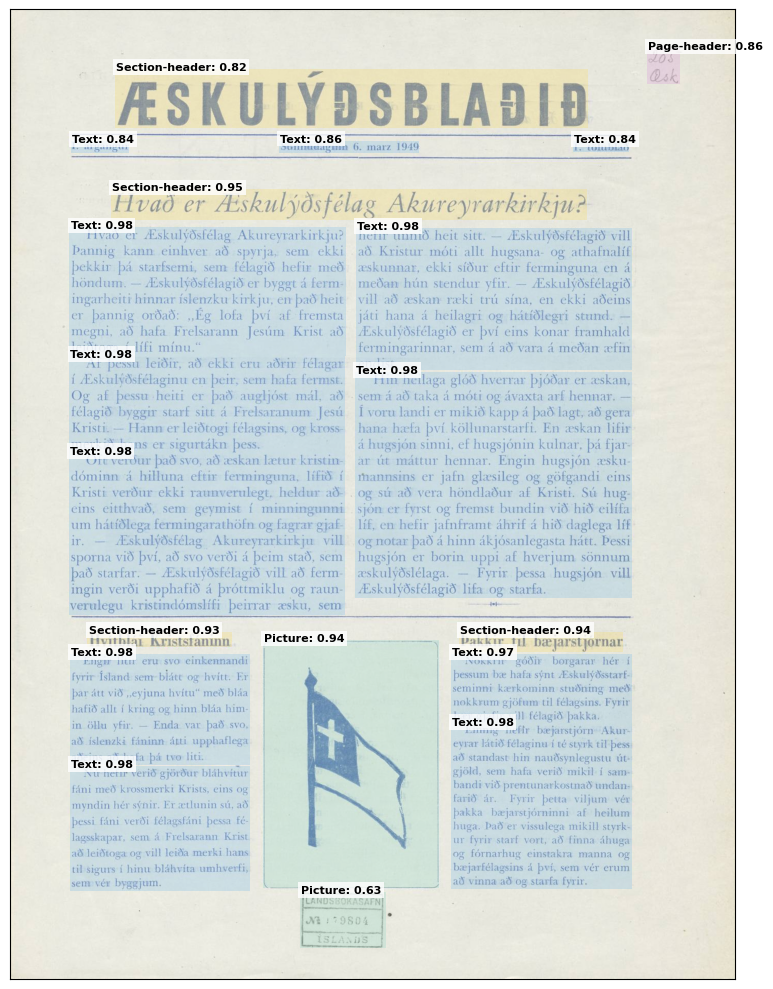

In [9]:
# image_url = "https://huggingface.co/spaces/ds4sd/SmolDocling-256M-Demo/resolve/main/example_images/annual_rep_14.png"
image_url = "https://timarit.is/files/74136591"
model_name = "ds4sd/docling-layout-heron-101"
threshold = 0.6

image = Image.open(requests.get(image_url, stream=True).raw).convert("RGB")
image_processor = RTDetrImageProcessor.from_pretrained(model_name)
model = RTDetrV2ForObjectDetection.from_pretrained(model_name)

boxes, labels, scores = get_predictions(image, model, image_processor, threshold)
annotate_image(image, boxes, labels, scores)

Fetching 1 files: 100%|██████████| 1/1 [00:00<00:00, 12787.51it/s]


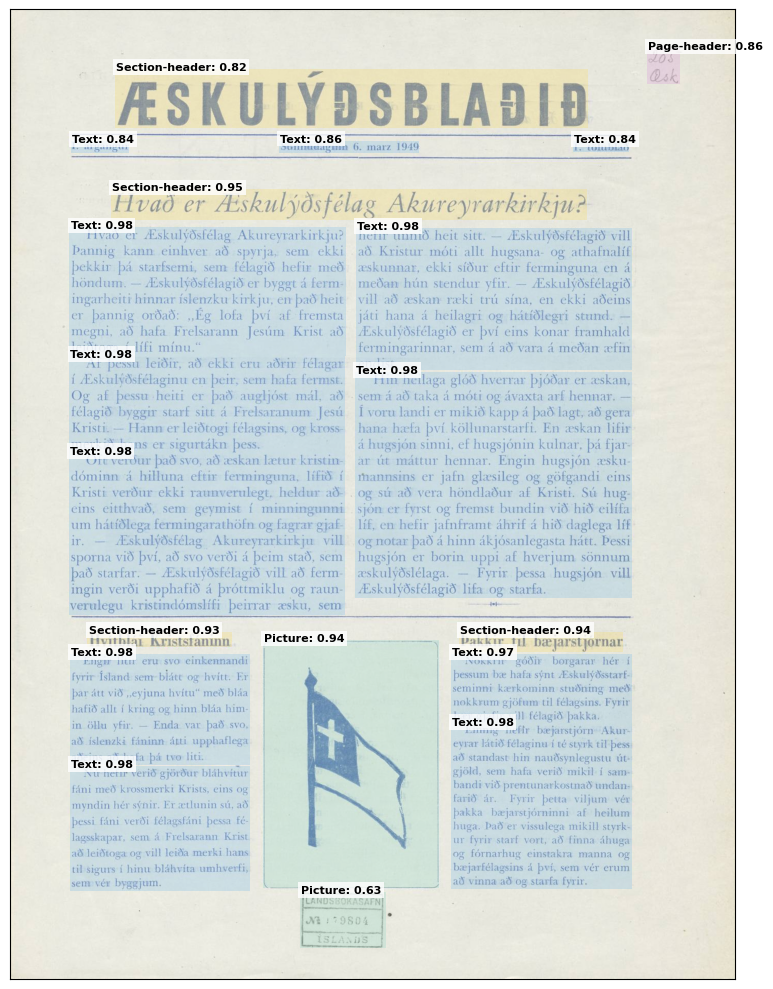

Fetching 1 files: 100%|██████████| 1/1 [00:00<00:00, 15141.89it/s]


<Figure size 640x480 with 0 Axes>

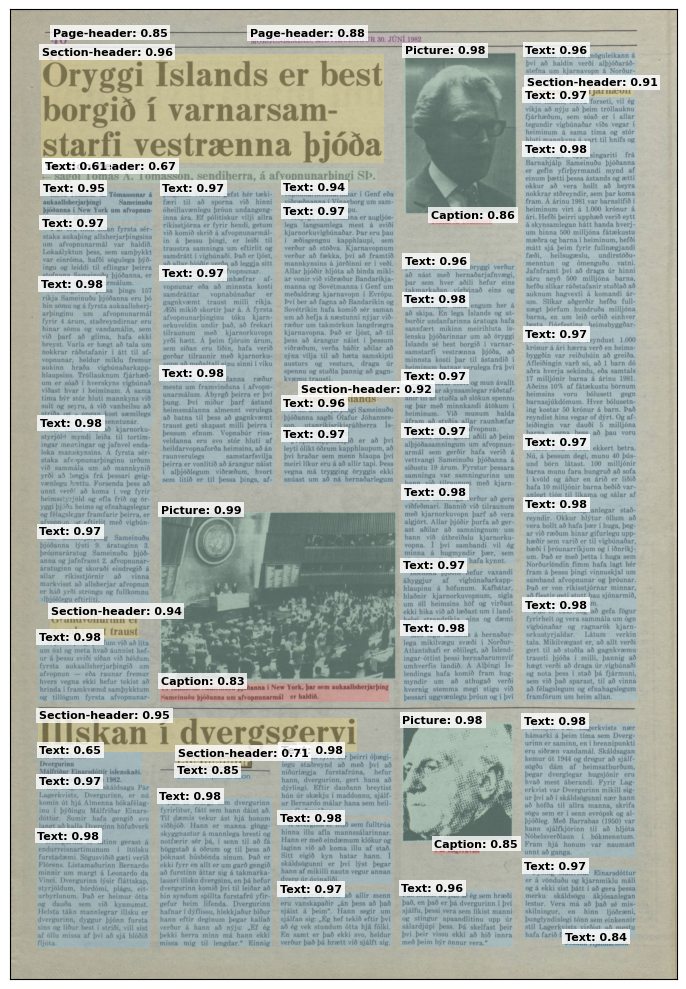

Fetching 1 files: 100%|██████████| 1/1 [00:00<00:00, 4899.89it/s]


<Figure size 640x480 with 0 Axes>

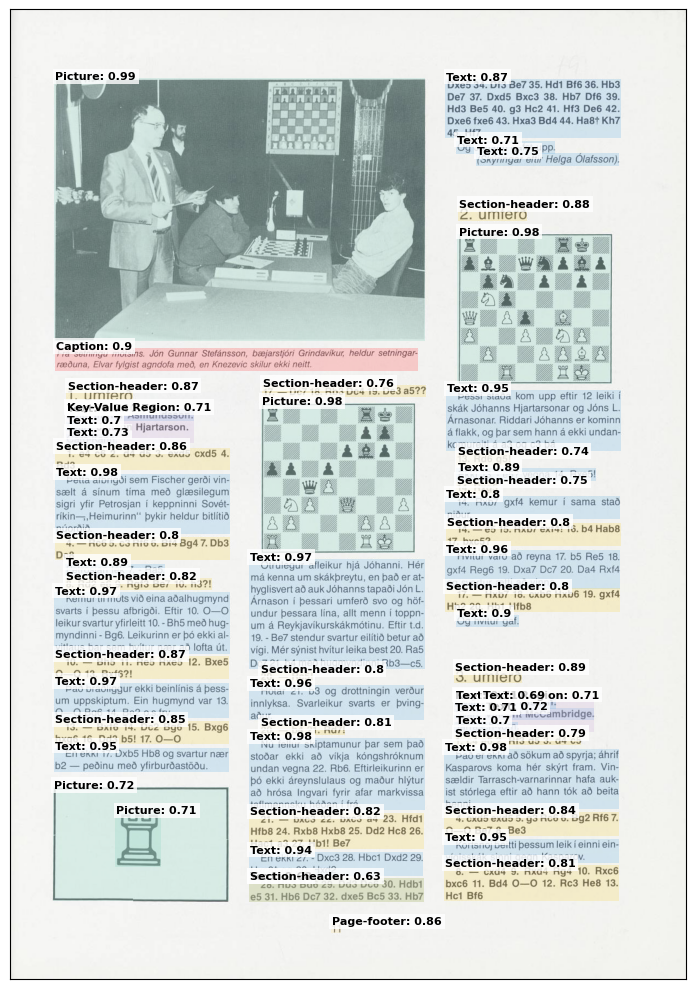

Fetching 1 files: 100%|██████████| 1/1 [00:00<00:00, 15420.24it/s]


<Figure size 640x480 with 0 Axes>

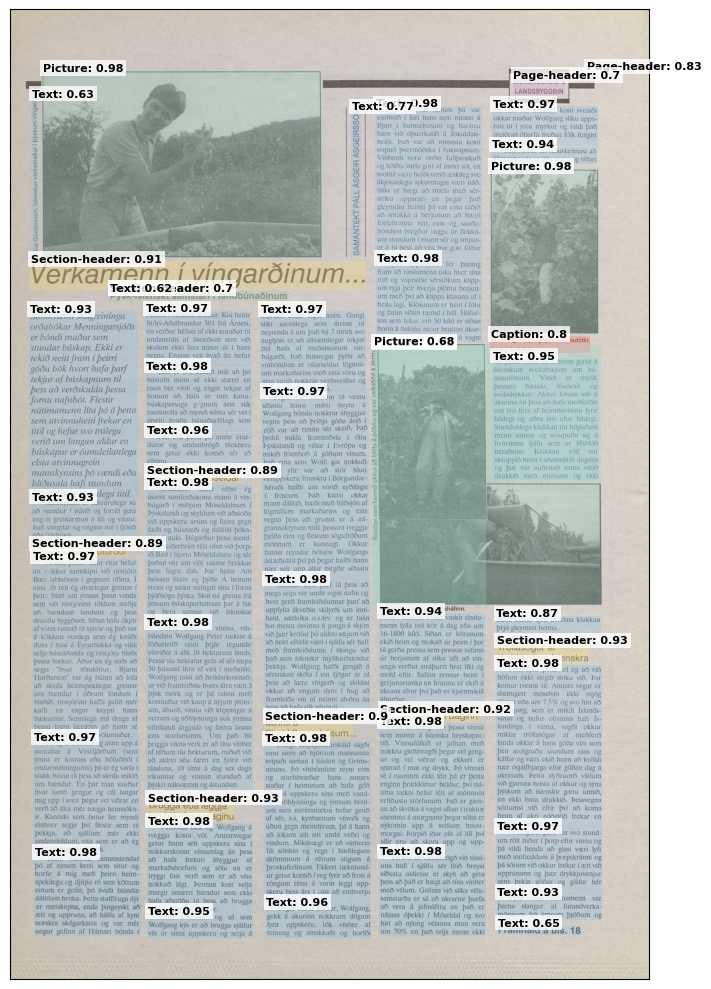

<Figure size 640x480 with 0 Axes>

In [15]:
urls = [
    "https://timarit.is/files/74136591",
    "https://timarit.is/files/58287988",
    "https://timarit.is/files/74200351",
    "https://timarit.is/files/48601326"
]

for image_url in urls:
    image = Image.open(requests.get(image_url, stream=True).raw).convert("RGB")
    image_processor = RTDetrImageProcessor.from_pretrained(model_name)
    model = RTDetrV2ForObjectDetection.from_pretrained(model_name)

    save_path = image_url.split("/")[-1] + "_annotated.png"
    boxes, labels, scores = get_predictions(image, model, image_processor, threshold)
    annotate_image(image, boxes, labels, scores, save_path=save_path)
